In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

import joblib

In [2]:
plt.style.use('tableau-colorblind10')
sns.set_style('whitegrid')

In [3]:
finaldf = pd.read_csv('DataFinal.csv', index_col=[0])
finaldf.head()

,Borough,Neighborhood,Building_Class_Category,Tax Class At Present,Block,Lot,Ease-Ment,Building Class At Present,address,Apartment Number,...,Total Units,Land_Square_Feet,Gross Square Feet,Year Built,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,sale date,latitude,longitude
9,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6399,8,NaN,S1,1653 BATH AVENUE,NaN,...,2,"1,260","1,440",1930.0,1,S1,800000,3/31/2022,40.605737,-74.008802
10,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6399,107,NaN,S1,1655 BATH AVENUE,NaN,...,2,"1,260","1,440",1930.0,1,S1,0,2/2/2022,40.605705,-74.008751
12,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6405,148,NaN,S1,1865 BATH AVENUE,NaN,...,2,"1,124","1,800",1920.0,1,S1,955000,10/28/2022,40.602952,-74.003951
16,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6442,32,NaN,S1,2014 BATH AVENUE,NaN,...,2,"1,245","1,596",1925.0,1,S1,0,7/25/2022,40.601019,-74.001314
21,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6461,141,NaN,A5,1173 SHORE PARKWAY,NaN,...,1,"1,661","1,392",1950.0,1,A5,843000,5/19/2022,40.602597,-74.012745


In [4]:
finaldf['Sale_Price'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])

0.000            0.0
0.250            0.0
0.500       375000.0
0.750       910000.0
0.900      1900000.0
0.950      3200000.0
0.990     12000000.0
0.997     32500000.0
1.000    228447600.0
Name: Sale_Price, dtype: float64

In [5]:
finaldf['Year Built'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])

0.000    1800.0
0.250    1920.0
0.500    1931.0
0.750    1960.0
0.900    1994.0
0.950    2006.0
0.990    2019.0
0.997    2021.0
1.000    2022.0
Name: Year Built, dtype: float64

In [6]:
mask = (finaldf['Year Built'] > 1900) & (finaldf['Sale_Price'] > 100000) & (finaldf['Sale_Price'] < 1e7)
finaldf = finaldf[mask]

In [7]:
finaldf.shape

(10588, 23)

In [8]:
req_cols = []

for col in finaldf.columns:
    is_na = round(finaldf[col].isna().sum() / len(finaldf) * 100, 2)
    if is_na < 50:
        req_cols.append(col)
    print(f"{col} has {is_na} % of nan values")

print(f"{len(req_cols)} has less than 50% of nan values")
finaldf = finaldf[req_cols]
print(finaldf.shape)

Borough has 0.0 % of nan values
Neighborhood has 0.0 % of nan values
Building_Class_Category has 0.0 % of nan values
Tax Class At Present has 0.0 % of nan values
Block has 0.0 % of nan values
Lot has 0.0 % of nan values
Ease-Ment has 100.0 % of nan values
Building Class At Present has 0.0 % of nan values
address has 0.0 % of nan values
Apartment Number has 98.05 % of nan values
Zip Code has 0.0 % of nan values
Residential_Units has 9.18 % of nan values
Commercial_Units has 9.1 % of nan values
Total Units has 9.1 % of nan values
Land_Square_Feet has 9.18 % of nan values
Gross Square Feet has 9.18 % of nan values
Year Built has 0.0 % of nan values
Tax_Class_At_Time_Of_Sale has 0.0 % of nan values
Building_Class_At_Time_Of_Sale has 0.0 % of nan values
Sale_Price has 0.0 % of nan values
sale date has 0.0 % of nan values
latitude has 16.75 % of nan values
longitude has 16.75 % of nan values
21 has less than 50% of nan values
(10588, 21)


In [9]:
cat_cols = finaldf.select_dtypes('object').columns
k = 0
cardinality_cols = []

for col in cat_cols:
    value_counts = finaldf[col].value_counts(normalize=True).round(2)
    if len(value_counts) > 5 or len(value_counts) < 2:
        cardinality_cols.append(col)
    else:
        print("====================================================================")
        print(col)
        print(value_counts)

cardinality_cols.remove('Neighborhood')
cardinality_cols.remove('Building_Class_At_Time_Of_Sale')
print(f"Removed Columns: {cardinality_cols}")
finaldf.drop(columns=cardinality_cols, axis=1, inplace=True)

Removed Columns: ['Building_Class_Category', 'Tax Class At Present', 'Building Class At Present', 'address', 'Commercial_Units', 'Total Units', 'Land_Square_Feet', 'Gross Square Feet', 'sale date']


In [10]:
finaldf['Neighborhood'].value_counts(normalize=True).round(2)

RIVERDALE                0.05
BAYCHESTER               0.03
SOUNDVIEW                0.03
WILLIAMSBRIDGE           0.03
EAST NEW YORK            0.03
                         ... 
DOWNTOWN-METROTECH       0.00
DOWNTOWN-FULTON FERRY    0.00
SPRING CREEK             0.00
BRONX PARK               0.00
FLUSHING MEADOW PARK     0.00
Name: Neighborhood, Length: 153, dtype: float64

In [12]:
neighborhood = finaldf['Neighborhood'].value_counts(normalize=True).round(2)
idx = np.where(neighborhood > 0.01)[0].max()
places = neighborhood.index[:idx]
finaldf['Neighborhood'] =finaldf['Neighborhood'].apply(lambda x: x if x in places else 'OTHER')
finaldf['Neighborhood'].value_counts(normalize=True)

OTHER                       0.644598
RIVERDALE                   0.045712
BAYCHESTER                  0.030601
SOUNDVIEW                   0.030128
WILLIAMSBRIDGE              0.028240
EAST NEW YORK               0.027012
THROGS NECK                 0.026351
BUSHWICK                    0.025784
BRONXDALE                   0.020684
BEDFORD STUYVESANT          0.019173
FLUSHING-NORTH              0.019078
SCHUYLERVILLE/PELHAM BAY    0.018323
MORRISANIA/LONGWOOD         0.017378
WAKEFIELD                   0.015961
BEDFORD PARK/NORWOOD        0.015584
CROWN HEIGHTS               0.015395
Name: Neighborhood, dtype: float64

In [13]:
building_class = finaldf['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True).round(2)
idx = np.where(building_class > 0.01)[0].max()
places = building_class.index[:idx]
finaldf['Building_Class_At_Time_Of_Sale'] =finaldf['Building_Class_At_Time_Of_Sale'].apply(lambda x: x if x in places else 'OTHER')
finaldf['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True)

OTHER    0.172459
B1       0.120797
A1       0.112580
C0       0.101152
A5       0.096430
B2       0.087930
D4       0.082452
B3       0.066868
A2       0.040895
B9       0.028712
A9       0.024084
S2       0.023801
C3       0.023423
C2       0.018417
Name: Building_Class_At_Time_Of_Sale, dtype: float64

In [14]:
finaldf.shape


(10588, 12)

In [15]:
num_cols = finaldf.select_dtypes('number').columns

low_var_cols = []
for col in num_cols:
    scaled = (finaldf[col] - finaldf[col].mean()) / finaldf[col].std()
    variance = scaled.var()
    if variance == 0 or finaldf[col].std() == 0:
        low_var_cols.append(col)
#     else:
#         print(col, variance)

finaldf.drop(columns=low_var_cols, axis=1, inplace=True)
print(f"Removed Columns: {low_var_cols}")
print(finaldf.shape, len(low_var_cols))

Removed Columns: []
(10588, 12) 0


In [17]:
finaldf['age'] = 2023 - (finaldf['Year Built'] + finaldf['Year Built']) // 2
finaldf.drop(['Zip Code', 'Year Built'], axis=1, inplace=True)

In [18]:
finaldf

,Borough,Neighborhood,Block,Lot,Residential_Units,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,latitude,longitude,age
9,3,OTHER,6399,8,1.0,1,OTHER,800000,40.605737,-74.008802,93.0
12,3,OTHER,6405,148,1.0,1,OTHER,955000,40.602952,-74.003951,103.0
21,3,OTHER,6461,141,1.0,1,A5,843000,40.602597,-74.012745,73.0
26,3,OTHER,6461,331,1.0,1,A5,880000,40.602899,-74.013811,78.0
61,3,OTHER,6372,4,2.0,1,B2,1388000,40.603822,-74.001930,93.0
...,...,...,...,...,...,...,...,...,...,...,...
8279,2,OTHER,3398,97,NaN,2,D4,211907,NaN,NaN,66.0
8280,2,OTHER,3398,97,NaN,2,D4,195529,NaN,NaN,66.0
8281,2,OTHER,3398,97,NaN,2,D4,192568,NaN,NaN,66.0
8282,2,OTHER,3398,97,NaN,2,D4,225000,NaN,NaN,66.0


In [19]:
corr = finaldf.drop('Sale_Price', axis=1).corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
print(f"columns dropped are: {drop}")
finaldf.drop(columns=drop, axis=1, inplace=True)

columns dropped are: []


/var/folders/z3/47hdqk450mddd9b8zlmz3jxr0000gn/T/ipykernel_67315/3160725106.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = finaldf.drop('Sale_Price', axis=1).corr()
/var/folders/z3/47hdqk450mddd9b8zlmz3jxr0000gn/T/ipykernel_67315/3160725106.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


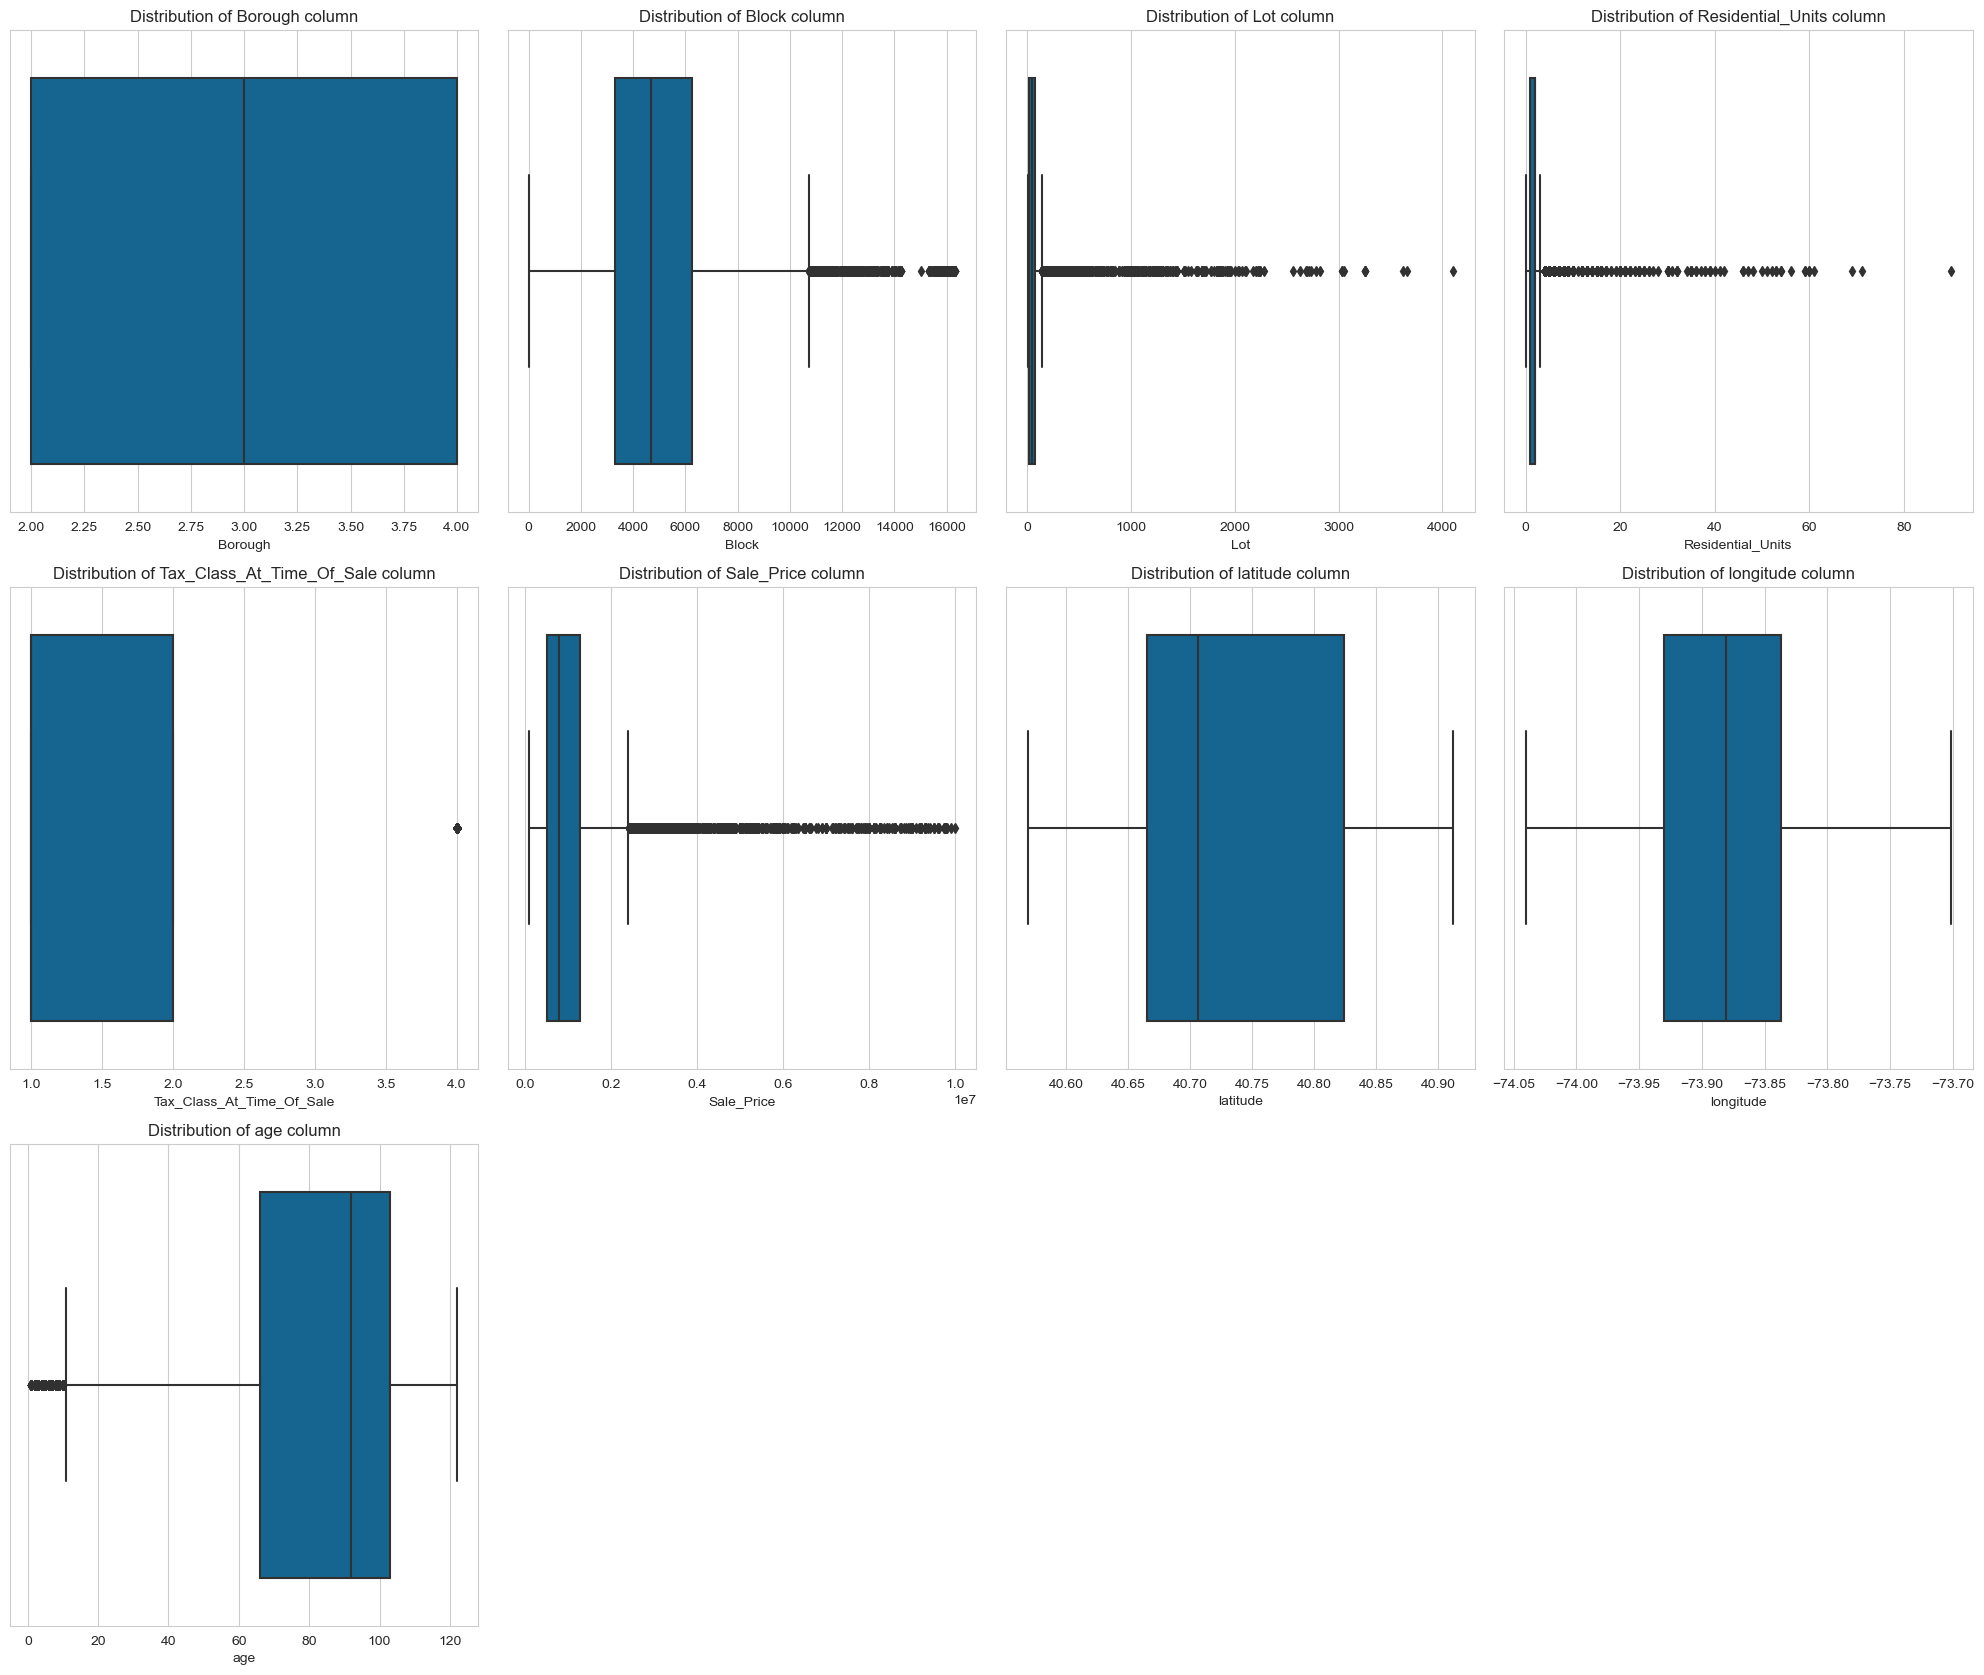

In [20]:
num_cols = finaldf.select_dtypes('number').columns
k = 0
plt.figure(figsize=(20, 100))
for col in num_cols:
    plt.subplot(18, 4, k + 1)
    sns.boxplot(data=finaldf, x=col)
    plt.xlabel(col)
    plt.title(f"Distribution of {col} column")
    k += 1
plt.tight_layout()

/var/folders/z3/47hdqk450mddd9b8zlmz3jxr0000gn/T/ipykernel_67315/2038062508.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = finaldf.drop('Sale_Price', axis=1).corr()


<Axes: >

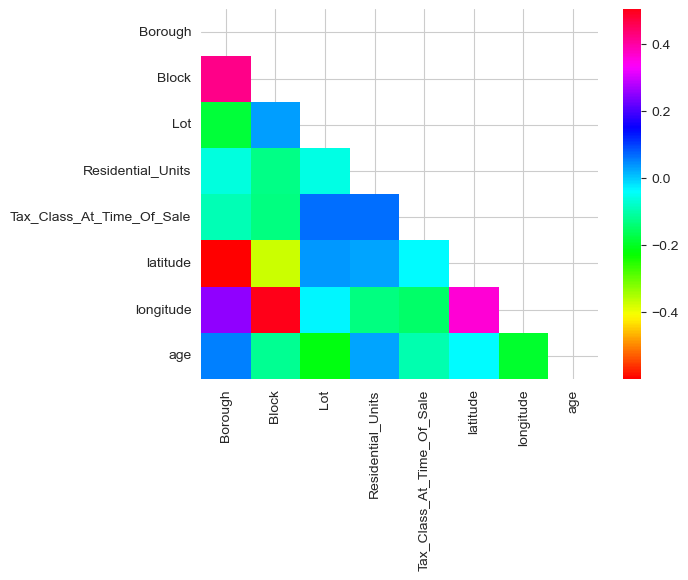

In [21]:
corr = finaldf.drop('Sale_Price', axis=1).corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, cmap='hsv')

In [22]:
finaldf.shape

(10588, 11)

In [23]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10588 entries, 9 to 8283
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Borough                         10588 non-null  int64  
 1   Neighborhood                    10588 non-null  object 
 2   Block                           10588 non-null  int64  
 3   Lot                             10588 non-null  int64  
 4   Residential_Units               9616 non-null   float64
 5   Tax_Class_At_Time_Of_Sale       10588 non-null  int64  
 6   Building_Class_At_Time_Of_Sale  10588 non-null  object 
 7   Sale_Price                      10588 non-null  int64  
 8   latitude                        8814 non-null   float64
 9   longitude                       8814 non-null   float64
 10  age                             10588 non-null  float64
dtypes: float64(4), int64(5), object(2)
memory usage: 992.6+ KB


In [24]:
drop_cols = ['Block', 'Lot']
finaldf.drop(columns=drop_cols, axis=1, inplace=True)

In [26]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10588 entries, 9 to 8283
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Borough                         10588 non-null  int64  
 1   Neighborhood                    10588 non-null  object 
 2   Residential_Units               9616 non-null   float64
 3   Tax_Class_At_Time_Of_Sale       10588 non-null  int64  
 4   Building_Class_At_Time_Of_Sale  10588 non-null  object 
 5   Sale_Price                      10588 non-null  int64  
 6   latitude                        8814 non-null   float64
 7   longitude                       8814 non-null   float64
 8   age                             10588 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 827.2+ KB


In [27]:
finaldf.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8807 entries, 9 to 8283
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Borough                         8807 non-null   int64  
 1   Neighborhood                    8807 non-null   object 
 2   Residential_Units               8807 non-null   float64
 3   Tax_Class_At_Time_Of_Sale       8807 non-null   int64  
 4   Building_Class_At_Time_Of_Sale  8807 non-null   object 
 5   Sale_Price                      8807 non-null   int64  
 6   latitude                        8807 non-null   float64
 7   longitude                       8807 non-null   float64
 8   age                             8807 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 688.0+ KB


In [28]:
finaldf.dropna(inplace=True)

In [29]:
finaldf.shape

(8807, 9)

In [32]:
def treat_categorical(finaldf):
    cat_cols = finaldf.select_dtypes('object').columns
    k = 0
    cardinality_cols = []
    for col in cat_cols:
        value_counts = finaldf[col].value_counts(normalize=True).round(2)
        if len(value_counts) > 5 or len(value_counts) < 2:
            cardinality_cols.append(col)
    return cardinality_cols

def get_low_variance_cols(finaldf):
    num_cols = finaldf.drop('Sale_Price', axis=1).select_dtypes('number').columns
    low_var_cols = []
    for col in num_cols:
        scaled = (finaldf[col] - brookdf[col].mean()) / finaldf[col].std()
        variance = scaled.var().round(2)
        if variance == 0 or finaldf[col].std() == 0:
            low_var_cols.append(col)
    return low_var_cols

def treat_na(finaldf):
    req_cols = []
    for col in finaldf.columns:
        is_na = round(finaldf[col].isna().sum() / len(finaldf) * 100, 2)
        if is_na < 50:
            req_cols.append(col)
    return req_cols
def wrangle(filepath):
    # Import data
    finaldf = pd.read_csv(filepath, index_col=[0])
    print(f"Imported Data, Shape: {finaldf.shape}")
    
    # Filter out the relevant data by sale_price and year_built
    mask = (finaldf['Year Built'] > 1900) & (finaldf['Sale_Price'] > 100000) & (finaldf['Sale_Price'] < 1e7)
    finaldf = finaldf[mask]
    print(f"Created mask, Shape: {finaldf.shape}")
    
    # Remove features which have majority missing values
    req_cols = treat_na(finaldf)
    finaldf = finaldf[req_cols]
    print(f"Filtered Columns by NaN, Shape: {finaldf.shape}")
    
    # Remove high and low cardinality categorical columns
    drop_cols = treat_categorical(finaldf)
    if 'Neighborhood' in drop_cols:
        drop_cols.remove('Neighborhood')
    if 'Building_Class_At_Time_Of_Sale' in drop_cols:
        drop_cols.remove('Building_Class_At_Time_Of_Sale')
    finaldf.drop(columns=drop_cols, axis=1, inplace=True)
    print(f"Dropped Columns by Cardinality, Shape: {finaldf.shape}")
    
    # Reduce the cardinality of neighborhood column
    neighborhood = finaldf['Neighborhood'].value_counts(normalize=True).round(2)
    idx = np.where(neighborhood > 0.01)[0].max()
    places = neighborhood.index[:idx]
    finaldf['Neighborhood'] =finaldf['Neighborhood'].apply(lambda x: x if x in places else 'OTHER')
    
    # Reduce the cardinality of building_class_at_sale column
    building_class = finaldf['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True).round(2)
    idx = np.where(building_class > 0.01)[0].max()
    places = building_class.index[:idx]
    finaldf['Building_Class_At_Time_Of_Sale'] =finaldf['Building_Class_At_Time_Of_Sale'].apply(lambda x: x if x in places else 'OTHER')
    
    
    # Calculate age of the house
    finaldf['age'] = 2023 - (finaldf['Year Built'] + finaldf['Year Built']) // 2
    
    # Drop unwanted columns
    drop = ['Zip Code', 'Year Built']
    finaldf.drop(columns=drop, axis=1, inplace=True)
    print(f"Dropped Columns by redundancy, Shape: {finaldf.shape}")
    
    # Drop columns with multicollinearity
    corr = finaldf.drop('Sale_Price', axis=1).corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
    finaldf.drop(columns=drop, axis=1, inplace=True)
    print(f"Dropped Columns by collinearity, Shape: {finaldf.shape}")
    
    # Drop unwanted columns
    drop_cols = ['Block', 'Lot']
    finaldf.drop(columns=drop_cols, axis=1, inplace=True)
    print(f"Dropped Columns manually, Shape: {finaldf.shape}")
    
    # Drop missing values
    finaldf.dropna(inplace=True)
    print(f"Dropped NaN values, Shape: {finaldf.shape}")
    
    return finaldf

In [33]:
NYC = wrangle('DataFinal.csv')
print(NYC.shape)
NYC.head()

Imported Data, Shape: (20569, 23)
Created mask, Shape: (10588, 23)
Filtered Columns by NaN, Shape: (10588, 21)
Dropped Columns by Cardinality, Shape: (10588, 12)
Dropped Columns by redundancy, Shape: (10588, 11)
Dropped Columns by collinearity, Shape: (10588, 11)
Dropped Columns manually, Shape: (10588, 9)
Dropped NaN values, Shape: (8807, 9)
(8807, 9)


/var/folders/z3/47hdqk450mddd9b8zlmz3jxr0000gn/T/ipykernel_67315/2498557543.py:74: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = finaldf.drop('Sale_Price', axis=1).corr()
/var/folders/z3/47hdqk450mddd9b8zlmz3jxr0000gn/T/ipykernel_67315/2498557543.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


,Borough,Neighborhood,Residential_Units,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,latitude,longitude,age
9,3,OTHER,1.0,1,OTHER,800000,40.605737,-74.008802,93.0
12,3,OTHER,1.0,1,OTHER,955000,40.602952,-74.003951,103.0
21,3,OTHER,1.0,1,A5,843000,40.602597,-74.012745,73.0
26,3,OTHER,1.0,1,A5,880000,40.602899,-74.013811,78.0
61,3,OTHER,2.0,1,B2,1388000,40.603822,-74.001930,93.0


In [34]:
NYC.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8807 entries, 9 to 8283
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Borough                         8807 non-null   int64  
 1   Neighborhood                    8807 non-null   object 
 2   Residential_Units               8807 non-null   float64
 3   Tax_Class_At_Time_Of_Sale       8807 non-null   int64  
 4   Building_Class_At_Time_Of_Sale  8807 non-null   object 
 5   Sale_Price                      8807 non-null   int64  
 6   latitude                        8807 non-null   float64
 7   longitude                       8807 non-null   float64
 8   age                             8807 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 688.0+ KB


In [35]:
viz_df = NYC.copy()


In [36]:
finaldf['Sale_Price'] = finaldf['Sale_Price'].astype(np.float64)
print(finaldf.dtypes)

Borough                             int64
Neighborhood                       object
Residential_Units                 float64
Tax_Class_At_Time_Of_Sale           int64
Building_Class_At_Time_Of_Sale     object
Sale_Price                        float64
latitude                          float64
longitude                         float64
age                               float64
dtype: object


In [37]:
median_home_price = viz_df['Sale_Price'].median()
median_home_price

860000.0

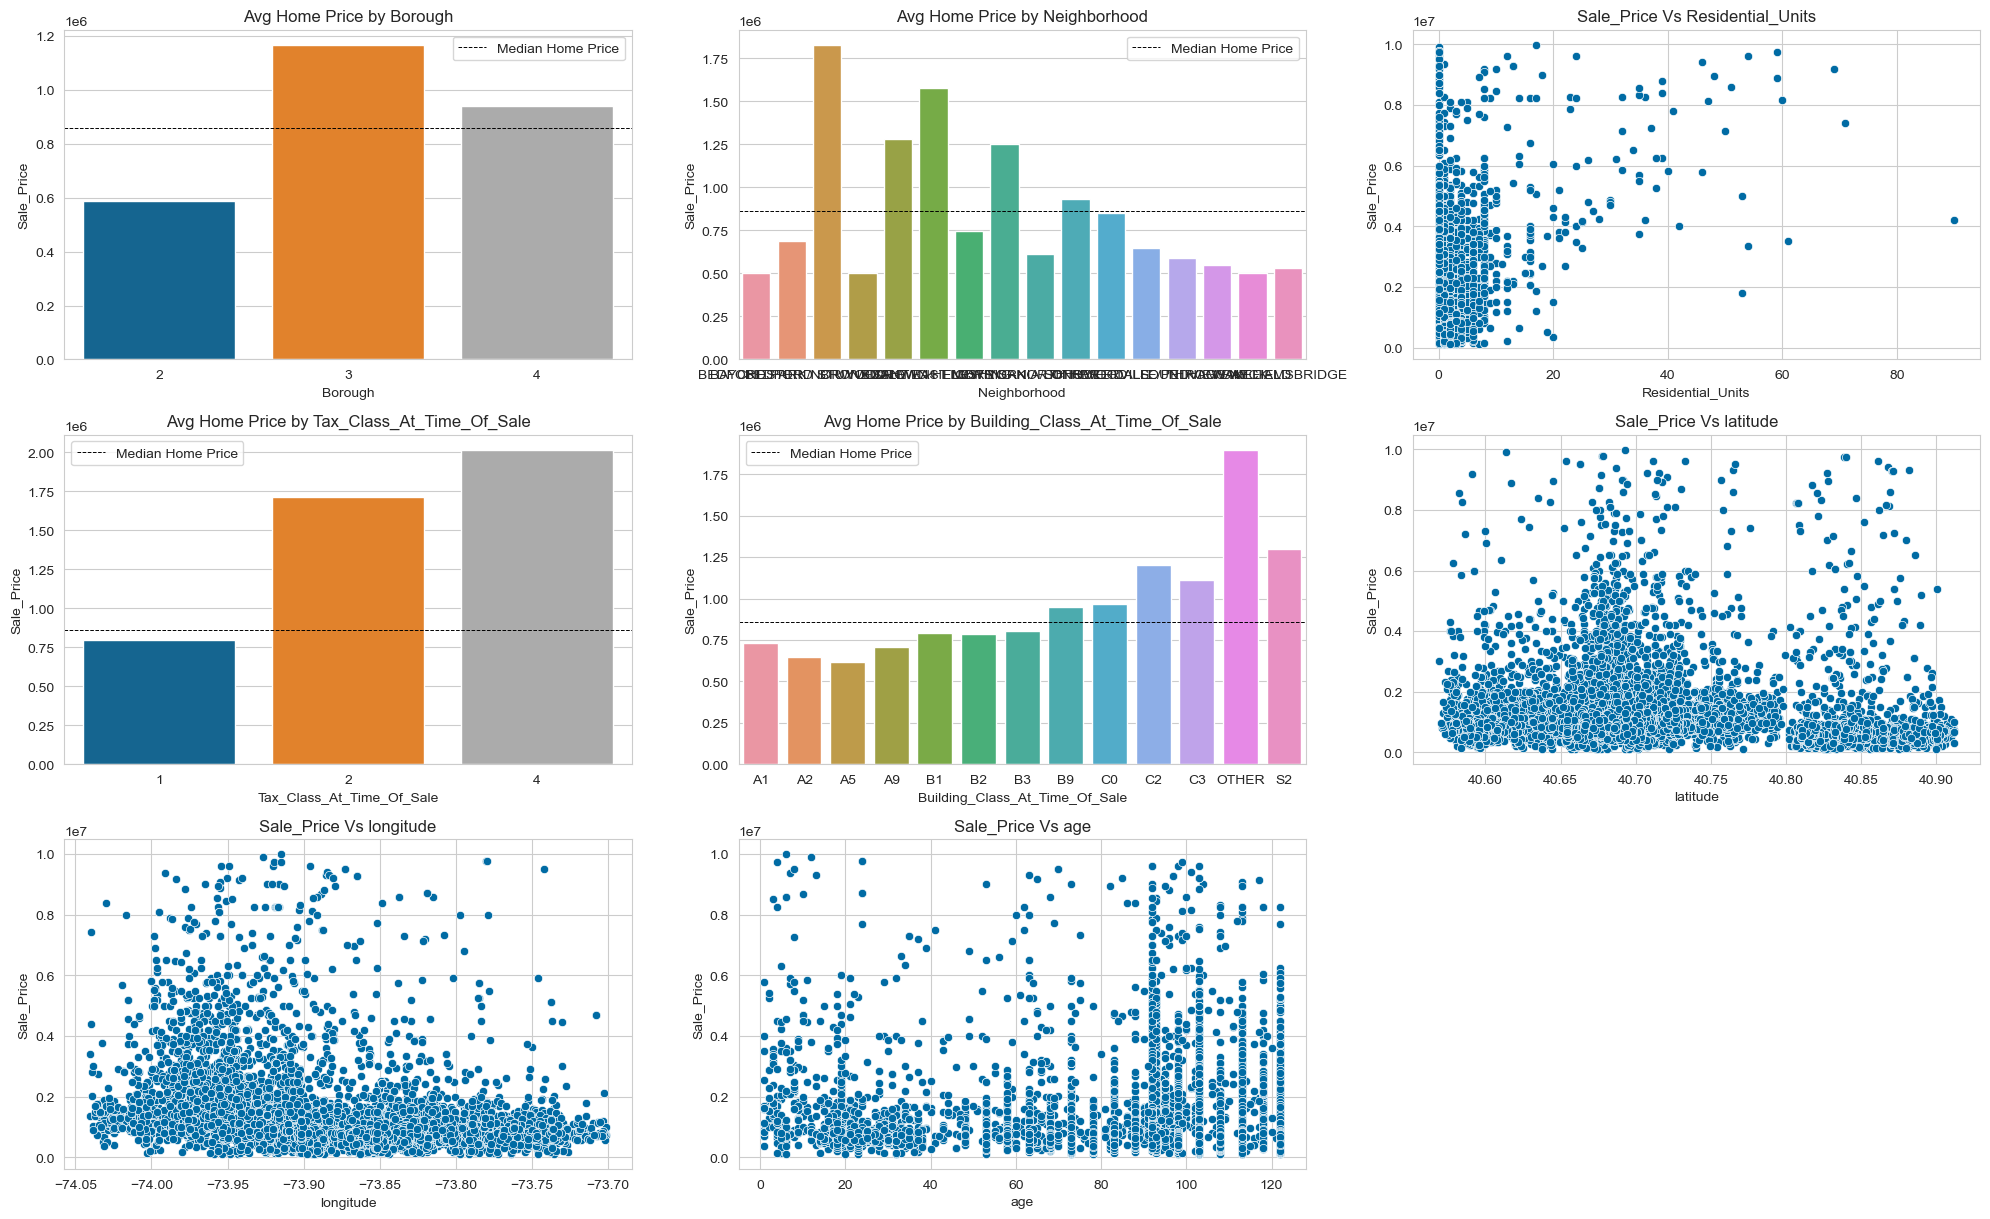

In [38]:
k = 0
plt.figure(figsize=(20, 20))
for col in viz_df.drop('Sale_Price', axis=1).columns:
    plt.subplot(5, 3, k + 1)
    if viz_df[col].dtype == 'float64':
        sns.scatterplot(data=viz_df, x=col, y='Sale_Price')
        plt.title(f"Sale_Price Vs {col}")
    else:
        group = viz_df[[col, 'Sale_Price']].groupby(by=col).median()
        sns.barplot(data=group, x=group.index, y='Sale_Price')
        plt.axhline(y=median_home_price, label='Median Home Price', color='black', linestyle='--', linewidth=0.7)
        plt.title(f"Avg Home Price by {col}")
        plt.legend()
    k += 1
plt.tight_layout()


<Axes: xlabel='Sale_Price', ylabel='Count'>

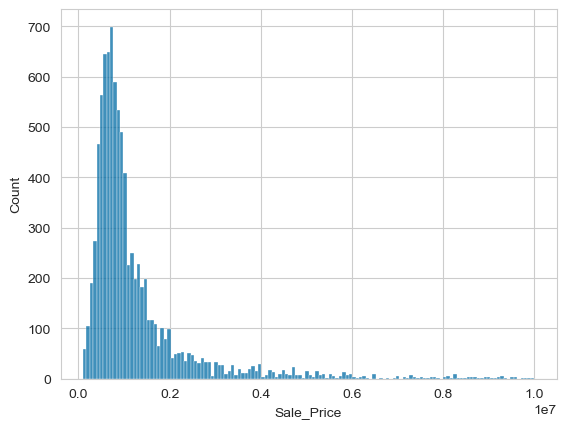

In [39]:
sns.histplot(viz_df['Sale_Price'])

<Axes: xlabel='Sale_Price', ylabel='Count'>

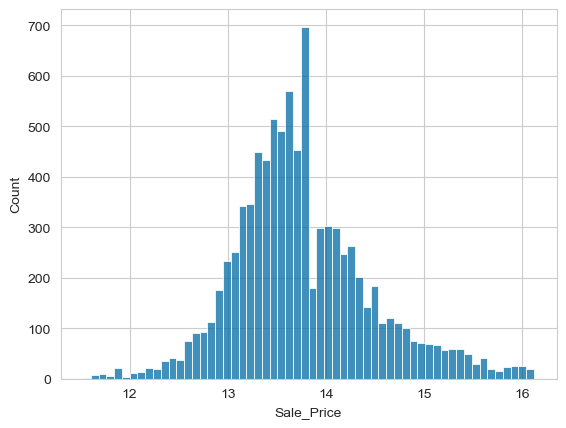

In [40]:
sns.histplot(np.log(viz_df['Sale_Price']))


In [41]:
X_train, X_test, y_train, y_test = train_test_split(NYC.drop('Sale_Price', axis=1), NYC['Sale_Price'], 
                                                    test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7045, 8), (1762, 8), (7045,), (1762,))

In [42]:
X_train.columns

Index(['Borough', 'Neighborhood', 'Residential_Units',
       'Tax_Class_At_Time_Of_Sale', 'Building_Class_At_Time_Of_Sale',
       'latitude', 'longitude', 'age'],
      dtype='object')

In [43]:
y_mean = NYC['Sale_Price'].mean()
print("Baseline R2 Score:", r2_score(y_test, [y_mean] * len(y_test)))
print("Baseline Root Mean Squared Error:", mean_squared_error(y_test, [y_mean] * len(y_test), squared=False))

Baseline R2 Score: -1.9881593269710507e-05
Baseline Root Mean Squared Error: 1273069.2055179493


In [44]:
def train_model(model):
    model.fit(X_train, np.log(y_train))
    print(f"Train R-Squared: {r2_score(y_train, np.exp(model.predict(X_train))).round(2)}")
    print(f"Test R-Squared: {r2_score(y_test, np.exp(model.predict(X_test))).round(2)}")
    print(f"Train Root Mean Squared Error: {mean_squared_error(y_train, np.exp(model.predict(X_train)), squared=False).round(2)}")
    print(f"Test Root Mean Squared Error: {mean_squared_error(y_test, np.exp(model.predict(X_test)), squared=False).round(2)}")
    return model

In [45]:
rf = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)
rf = train_model(rf)

Train R-Squared: 0.91
Test R-Squared: 0.59
Train Root Mean Squared Error: 375965.8
Test Root Mean Squared Error: 814250.39


In [46]:
params = {
    'randomforestregressor__n_estimators': np.arange(25, 126, 25),
    'randomforestregressor__min_samples_split': np.arange(2, 26, 5)
}
rf_grid = RandomizedSearchCV(
    estimator = rf,
    param_distributions=params,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rf_grid = train_model(rf_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train R-Squared: 0.84
Test R-Squared: 0.59
Train Root Mean Squared Error: 506393.37
Test Root Mean Squared Error: 813971.26


In [47]:
rf_grid.best_estimator_


Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Neighborhood',
                                     'Building_Class_At_Time_Of_Sale'])),
                ('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(min_samples_split=7, n_estimators=125,
                                       n_jobs=-1, random_state=42))])

In [48]:
xgb = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    XGBRegressor(random_state=42, n_jobs=-1),
)
xgb = train_model(xgb)

Train R-Squared: 0.85
Test R-Squared: 0.54
Train Root Mean Squared Error: 489315.29
Test Root Mean Squared Error: 860872.29


In [49]:
cat = CatBoostRegressor(
    cat_features=list(X_train.select_dtypes('object').columns),
    verbose=0
)
cat = train_model(cat)

/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Train R-Squared: 0.72
Test R-Squared: 0.55
Train Root Mean Squared Error: 663227.87
Test Root Mean Squared Error: 854856.82


/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


/Users/kdot/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


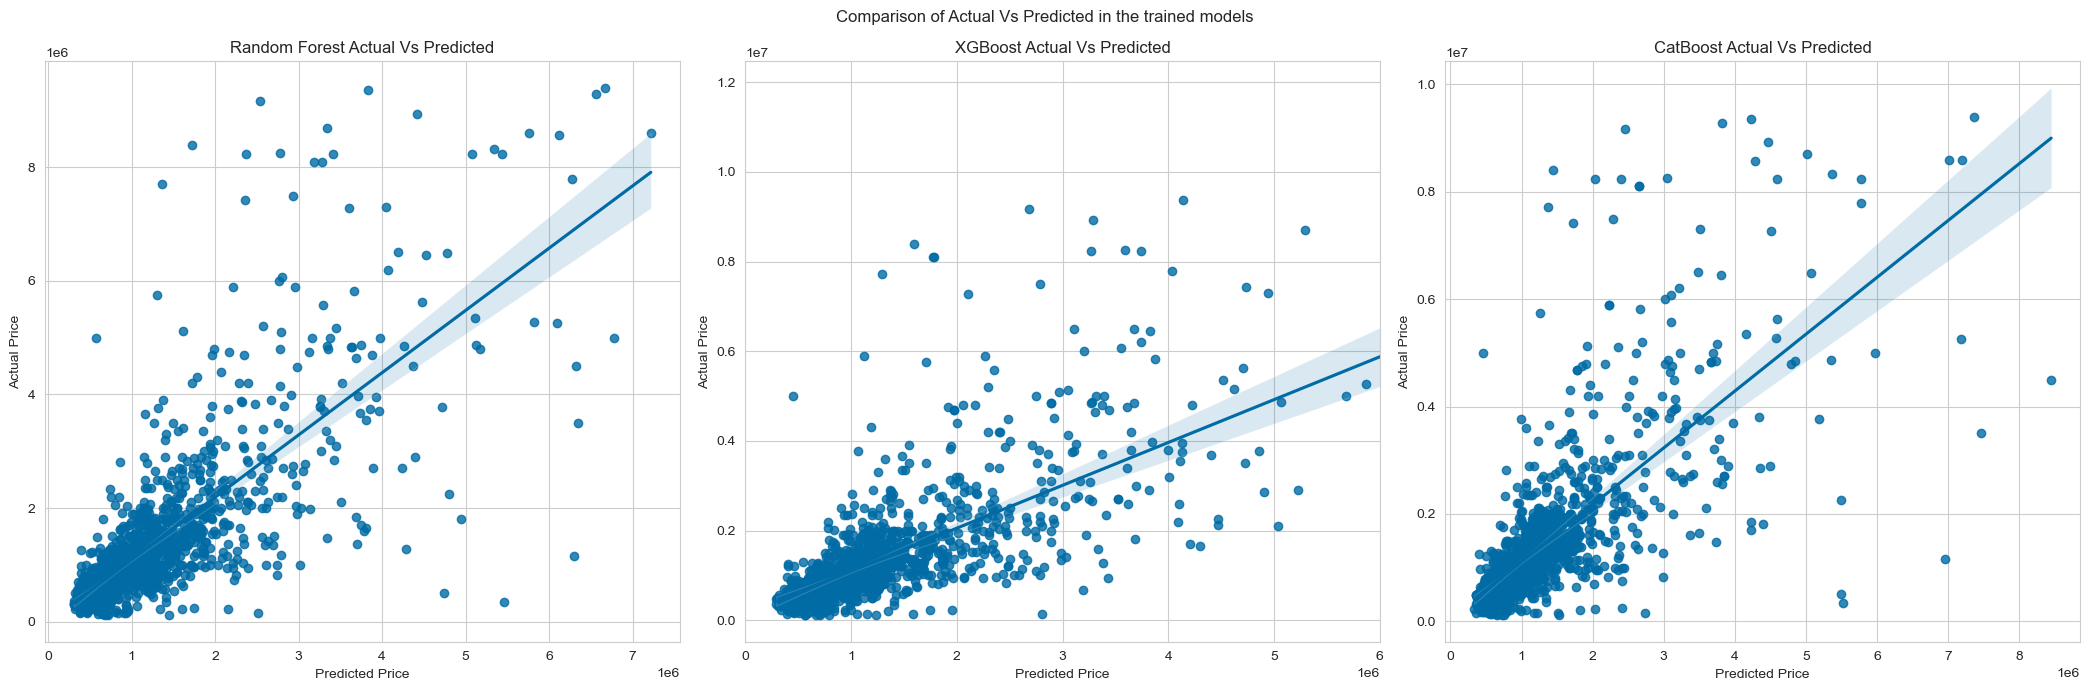

In [50]:
plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1)
preds = np.exp(rf_grid.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forest Actual Vs Predicted');

plt.subplot(1, 3, 2)
preds = np.exp(xgb.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlim(0, 6e6)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Actual Vs Predicted');

plt.subplot(1, 3, 3)
preds = np.exp(cat.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('CatBoost Actual Vs Predicted');

plt.suptitle('Comparison of Actual Vs Predicted in the trained models')
plt.tight_layout()


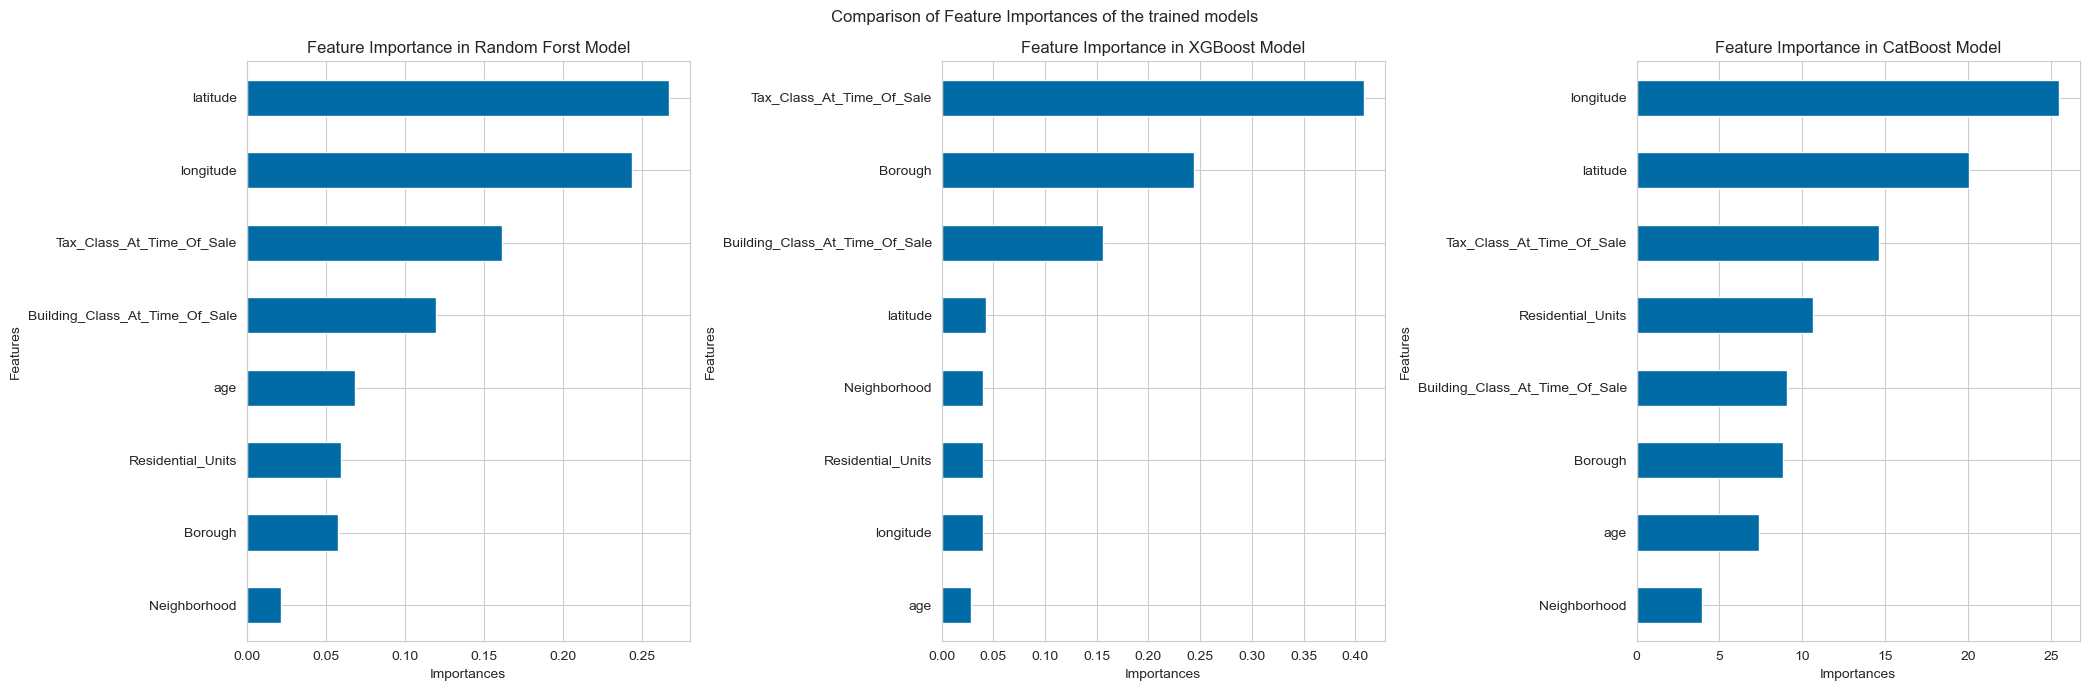

In [51]:
plt.figure(figsize=(21, 7))
feat_imp = rf_grid.best_estimator_.named_steps['randomforestregressor'].feature_importances_
rf_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 1)
rf_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forst Model');

feat_imp = xgb.named_steps['xgbregressor'].feature_importances_
xgb_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 2)
xgb_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in XGBoost Model');

feat_imp = cat.get_feature_importance()
cat_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 3)
cat_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost Model')

plt.suptitle('Comparison of Feature Importances of the trained models')
plt.tight_layout();

In [52]:
joblib.dump(rf_grid, 'randomforest.pkl', compress=9)

['randomforest.pkl']

In [53]:
joblib.dump(xgb, 'xgboost.pkl', compress=9)

['xgboost.pkl']

In [54]:
joblib.dump(cat, 'catboost.pkl', compress=9)

['catboost.pkl']

In [64]:
def predict_house_price(Borough, Neighborhood, Residential_Units,
       Tax_Class_At_Time_Of_Sale, Building_Class_At_Time_Of_Sale, 
       latitude, longitude, age):
    
    params_dict = {
        'Borough': Borough,
        'Neighborhood': Neighborhood,
        'Residential_Units': Residential_Units,
        'Tax_Class_At_Time_Of_Sale': Tax_Class_At_Time_Of_Sale,
        'Building_Class_At_Time_Of_Sale': Building_Class_At_Time_Of_Sale,
        'latitude': latitude,
        'longitude': longitude,
        'age': age
    }
    
    df = pd.DataFrame(params_dict, index=[0])
    
    with open('xgboost.pkl', 'rb') as f:
        xgb = joblib.load(f)
        
    xgb_pred = xgb.predict(df)
    
    avg = (np.exp(xgb_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"

In [65]:
predict_house_price(
    Borough = 3,
    Neighborhood = "BATH BEACH",
    Residential_Units = 2, 
    Tax_Class_At_Time_Of_Sale = 1,
    Building_Class_At_Time_Of_Sale = 'S2',
    latitude = 40.6060585,
    longitude = -74.0092519,
    age = 97
)

'The Predicted House Price is $975430.375'